# Using siamese LSTM  based comprehension scores for predicting public understanding of science

### 1. Import the libraries

In [130]:
# This Source Code Form is subject to the terms of the MPL
# License. If a copy of the same was not distributed with this
# file, You can obtain one at
# https://github.com/akhilpandey95/pubundsci/blob/master/LICENSE.

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### 2. Read the data

#### 2.1 Load the dataset as a Dataframe

In [30]:
# load "sampled_dataset_charlie" as a dataframe
data = pd.read_csv('sampled_dataset_charlie.csv')

# remove unnecessary columns retain 4, 5, 6, 7, 8 columns
data = data.iloc[:, [4, 5, 6, 7, 8]]

# rename col names
data = data.rename(columns={'similarity_score': 'sim_score'})
data = data.rename(columns={'yules_i_for_abs': 'lex_div'})
data = data.rename(columns={'avg_word_len_abs': 'avg_w_len'})
data = data.rename(columns={'avg_sen_len_abs': 'avg_s_len'})
data = data.rename(columns={'freq_of_words_great_sent_len_abs': 'fwgavl'})

# add a new class label
# if sim_score is between 0.0 to 0.33, then pubund is 'low'
# if sim_score is between 0.33 to 0.66, then pubund is 'med'
# if sim_score is between 0.66 to 1.0, then pubund is 'high'
attach_pubund_label = lambda x: 'high' if x > np.divide(2, 3) else 'med' if x > np.divide(1, 3) and x < np.divide(2, 3) else 'low'

# apply the function
data = data.assign(pubund = [attach_pubund_label(x) for x in tqdm(data['sim_score'])])

# display the head of the dataframe
data.head()

100%|██████████| 17736/17736 [00:00<00:00, 288259.16it/s]


,sim_score,lex_div,avg_w_len,avg_s_len,fwgavl,pubund
0,0.062027,30.970588,7.005128,194.125000,93,low
1,0.170682,15.113127,6.085714,156.818182,100,low
2,0.265519,15.810219,5.593074,216.571429,93,low
3,0.147733,14.613527,5.782609,123.800000,41,low
4,0.151497,19.031532,5.637405,172.900000,124,low


#### 2.2 Visualize the features vs response in a scatterplot matrix

/home/hector/.pyenv/versions/3.6.5/envs/jupyter/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


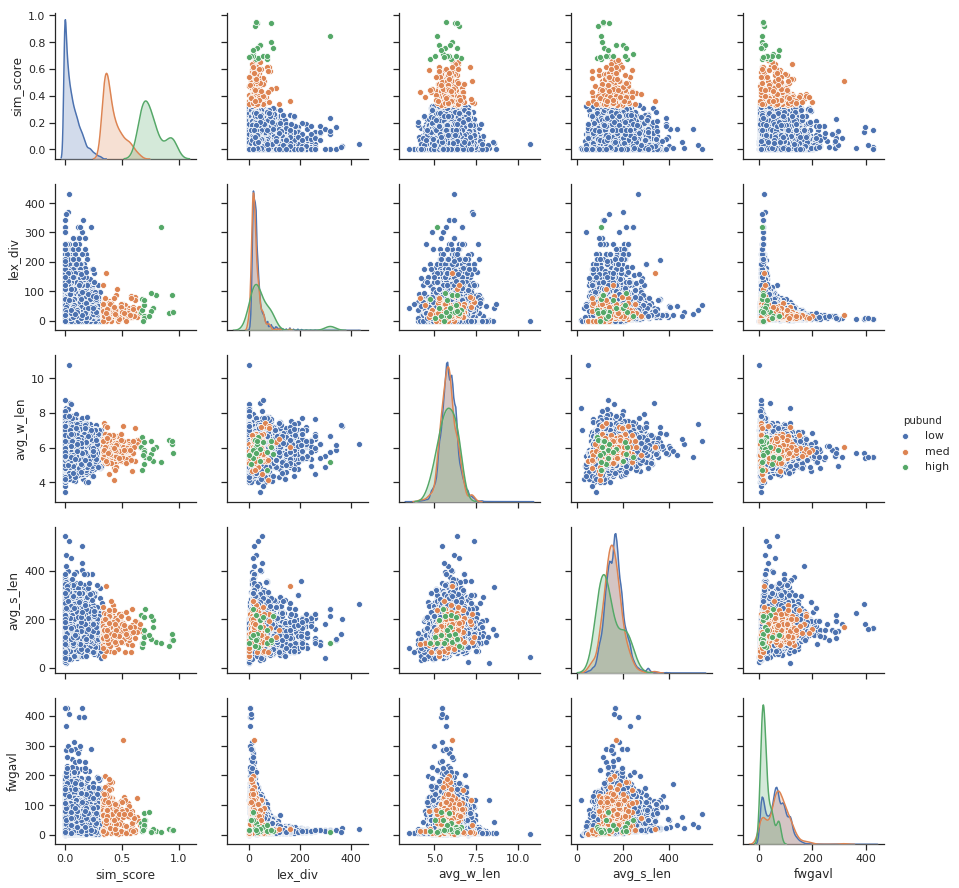

In [34]:
# set the sns style as ticks
sns.set(style='ticks')

# load the scatterplot matrix
sns.pairplot(data, hue='pubund')

#### 2.3 Visualize the boxplots for all features

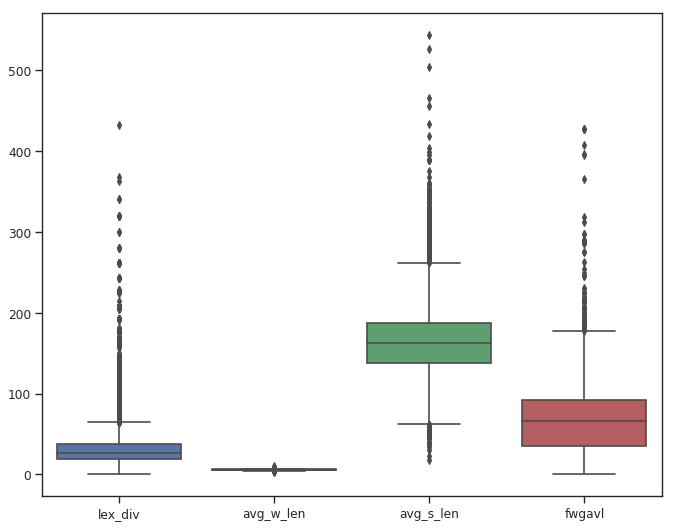

In [40]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# create a boxplot for all the features
sns.boxplot(data=data.iloc[:, [1, 2, 3, 4]])

#### 2.4 Visualize the violinplots for all classes against lexical diversity

/home/hector/.pyenv/versions/3.6.5/envs/jupyter/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


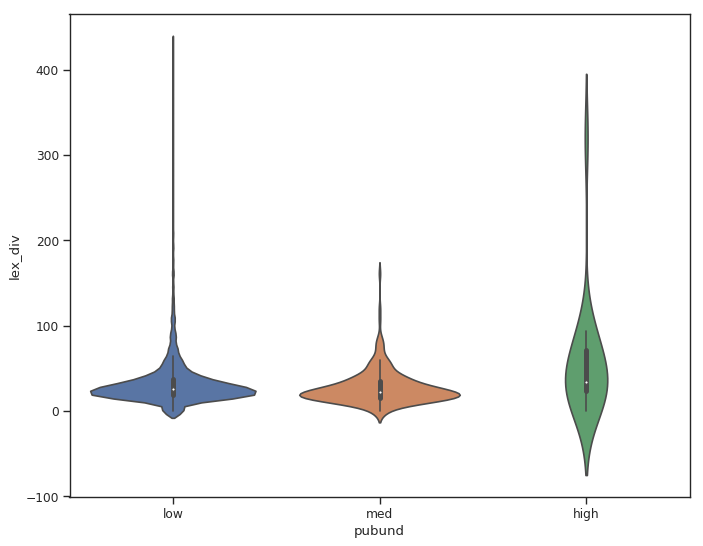

In [52]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# create a boxplot for all the features
sns.violinplot(x='pubund', y='lex_div', data=data)

### 3. Classifying scientific articles into low, med, high

#### 3.1 LDA Classifier

##### 3.1.1 Prepare X, y variables and include all the features

In [119]:
# create two variables X, y where X
# will store all the features and y
# will be the response variable
X = np.array(data.iloc[:, 1:5])
y = np.array(list(map(lambda x: 1 if x == 'high' else 2 if x == 'med' else 3, data['pubund'])))

##### 3.1.2 Transform X, and split the data into test and train (70, 30)

In [120]:
# transform X
X_LDA = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)

# use train_test_split to split the data
X_train, X_test, y_train, y_test = train_test_split(X_LDA, y, test_size=0.3, random_state=2018)

##### 3.1.3 Fit the LDA model

In [121]:
# load the LDA classifier object
lda = LinearDiscriminantAnalysis(n_components=2)

# 10 fold validation split
kf = KFold(n_splits=10, random_state=None, shuffle=False)
val_errors = []
train_errors = []

# test train split
for train_index, val_index in kf.split(X_train):
    X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    lda.fit(X_train_kf, y_train_kf)
    val_pred = lda.predict(X_val_kf)
    train_pred = lda.predict(X_train_kf)
    val_errors.append(metrics.accuracy_score(y_val_kf,val_pred))
    train_errors.append(metrics.accuracy_score(y_train_kf, train_pred))

# train again on the entire data
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

##### 3.1.4. Errors, Precision, Recall, F-1 score for LDA Classifier

In [122]:
# Mean in sample accuracy score with 95% CI
score = cross_val_score(lda, X_train_kf, y_train_kf, cv=5)
print("In sample accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# Mean out of sample accuracy score with 95% CI
score = cross_val_score(lda, X_val_kf, y_val_kf, cv=5)
print("Out of sample accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# accuracy
pred = lda.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("Test Accuracy:   %0.3f" % score)

In sample accuracy: 0.98 (+/- 0.00)
Out of sample accuracy: 0.99 (+/- 0.00)
Test Accuracy:   0.984


##### 3.1.5. Decision boundary for LDA Classifier

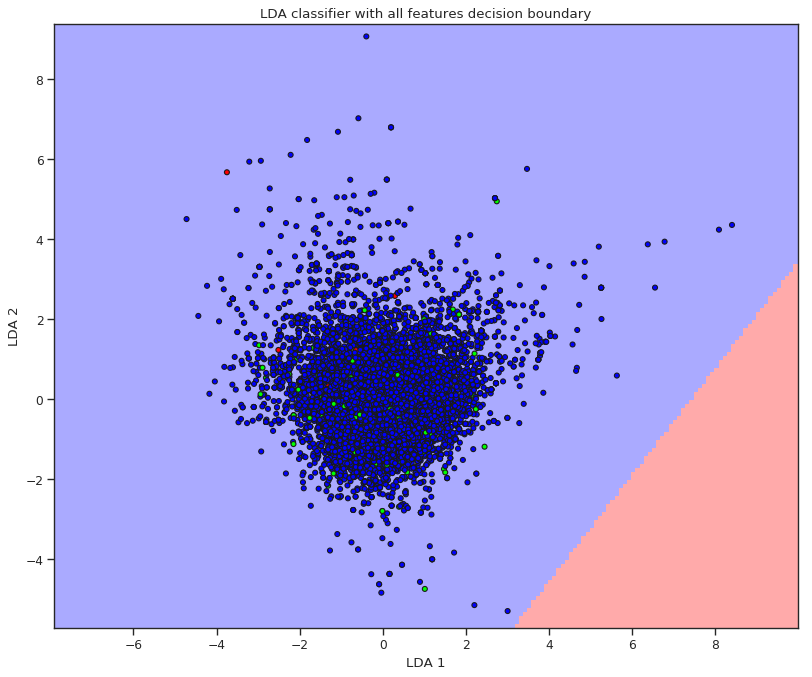

In [128]:
from matplotlib.colors import ListedColormap
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_LDA[:, 0].min() - 1, X_LDA[:, 0].max() + 1
y_min, y_max = X_LDA[:, 1].min() - 1, X_LDA[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X_LDA[:, 1], X_LDA[:, 0], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks()
plt.yticks()
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.title('LDA classifier with all features decision boundary')
plt.show()

#### 3.2 KNN classifier

##### 3.2.1 Train Test split for the KNN classifier (70, 30)

In [129]:
# use train_test_split to split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)

##### 3.2.2 Run a simulation for k=1 to 50 to find the best value of neighbors

In [131]:
# create a list that stores the accuracy score
# for every value of k
scores = []

# let us perform a 10 fold cross validation
for k in tqdm(range(1, 50)):
    knn_k = KNeighborsClassifier(n_neighbors=k)
    s = cross_val_score(knn_k, X_train, y_train, cv=10, scoring='accuracy')
    scores.append(s.mean())

100%|██████████| 49/49 [00:07<00:00,  6.63it/s]


##### 3.2.3 Visualize the errors to decide on the best value for k

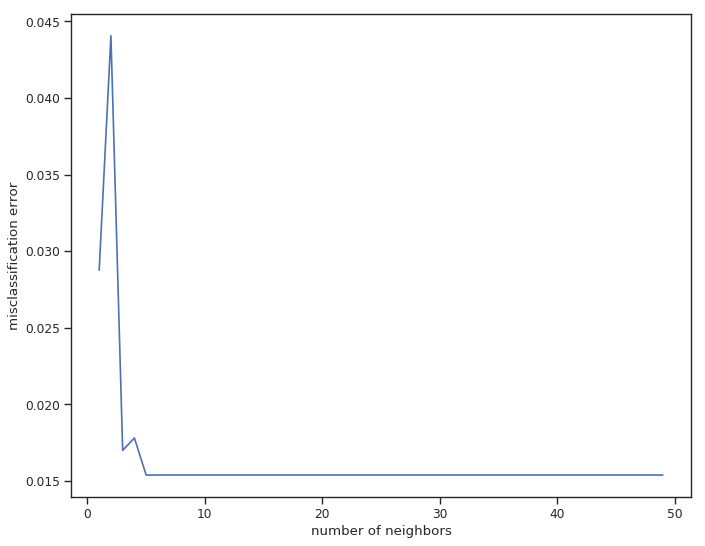

In [132]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# plot misclassification error vs k
plt.plot(list(range(1, 50)), [1-x for x in scores])
plt.xlabel('number of neighbors')
plt.ylabel('misclassification error')
plt.show()

##### 3.2.4 Fit the KNN model with k=5

In [141]:
# load the classifier object with k = 5
knn = KNeighborsClassifier(n_neighbors=5)

# 10 fold validation split
kf = KFold(n_splits=10, random_state=None, shuffle=False)
val_errors = []
train_errors = []

# test train split
for train_index, val_index in kf.split(X_train):
    X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    knn.fit(X_train_kf, y_train_kf)
    val_pred = knn.predict(X_val_kf)
    train_pred = knn.predict(X_train_kf)
    val_errors.append(metrics.accuracy_score(y_val_kf,val_pred))
    train_errors.append(metrics.accuracy_score(y_train_kf, train_pred))

# train again on the entire data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [142]:
# Mean in sample accuracy score with 95% CI
score = cross_val_score(knn, X_train_kf, y_train_kf, cv=5)
print("In sample accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# Mean out of sample accuracy score with 95% CI
score = cross_val_score(knn, X_val_kf, y_val_kf, cv=5)
print("Out of sample accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# accuracy
pred = knn.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("Test Accuracy:   %0.3f" % score)

In sample accuracy: 0.98 (+/- 0.00)
Out of sample accuracy: 0.99 (+/- 0.00)
Test Accuracy:   0.985
